# Uncovering the shift in beer consumption trends: a deep dive into the journey of beer, from its place of brewing to your glass

## imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math

import src.data.wrangling as wrangling
from src.data.distances import load_distances, convert_dict_to_table, compute_distances
from src.data.state_counts import get_monthly_counts_usa, get_state_adjacency_matrix, sort_matrix_by_diagonal
from src.data.plots import *
from src.data.breweries import *
from src.data.load_data import *
import src.data.loader as loader

from src.utils.data_utils import *

## Loading the data into dataframes

This part loads the data from the specified path from the .tar.gz files and saves them as .csv. Already existing .csv will be loaded but not created. clean_load can be set to True to clean all existing .csv and creating them.

In [ ]:
data = loader.load('data/raw/', 'data/clean', clean_load=True)
wrangling.clean_data('data/clean', clean_load=False)

This loads the data from already cleaned .csv files.

In [2]:
usa_ratings, breweries  = load_all_usa_data()


# Choosing the USA

Our choice to focus on the USA was done after looking at the distribution of the reviews and of the breweries.

In [ ]:
# This code generates an interactive map but slows down everything due to it being in a function, please look at the datastory to see the output
#code = get_countries_code()
#generate_choropleth_map(breweries, code, "nbr_beers", "Distribution of breweries in the world", "Number of breweries")

## Locality of Beer consumption

For each state we look at the proportion of reviews that are made on local beers (from the same state), national beers (beers from other states) or foreign beers.

In [3]:
# merge each ratings with its corresponding brewery
usa_ratings_merged = merge_ratings_breweries(usa_ratings, breweries)
# get all american states
states = get_states_from_df(usa_ratings_merged)

#### Top 12 states with the highest local reviews ratio 

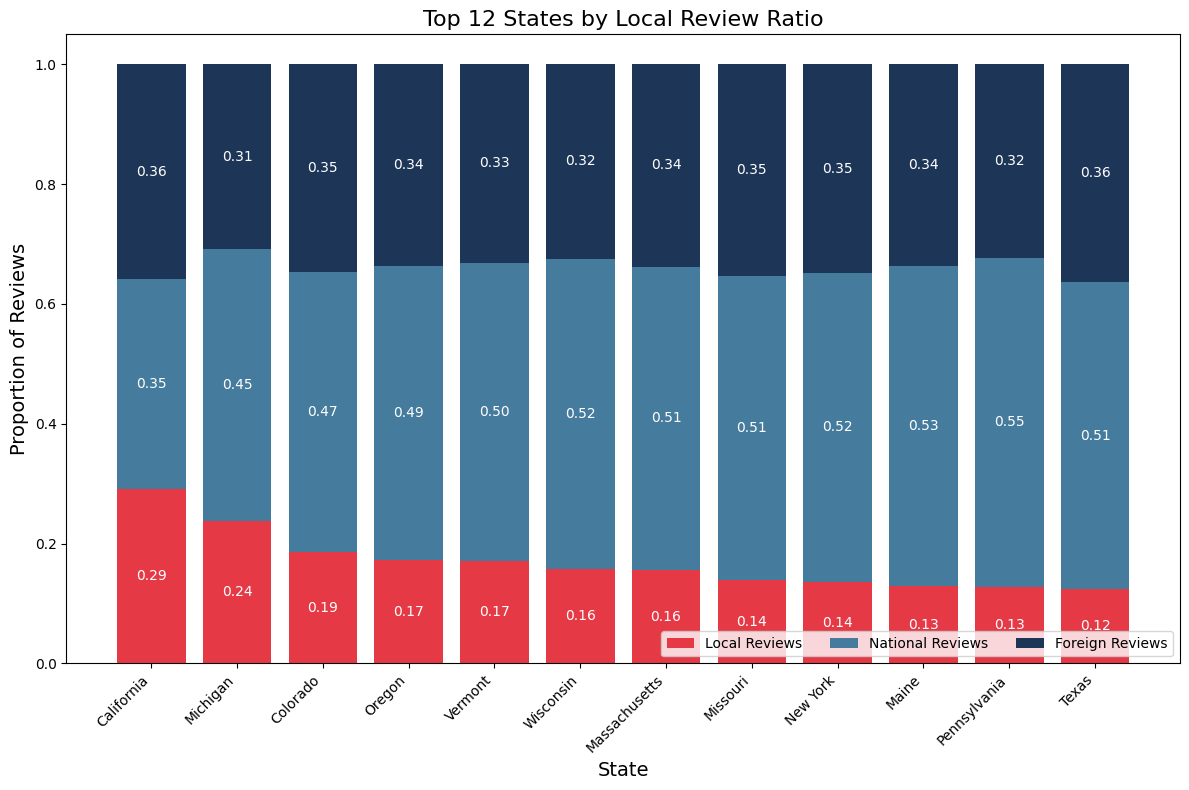

In [4]:
# Plot the top 12 states with the highest local reviews ratio

us_colors = {
    "local_count": "#e63946",
    "national_count": "#457b9d",
    "foreign_count": "#1d3557"
}

top_n_states = 12

fig, ax = plot_provenance(usa_ratings_merged, states, top_k=top_n_states, sort_option="local_count", 
                          ascending=False, width=0.8, as_ratio=True, colors=us_colors)

ax.set_title(f'Top {top_n_states} States by Local Review Ratio', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Proportion of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Top 12 states with the highest review count

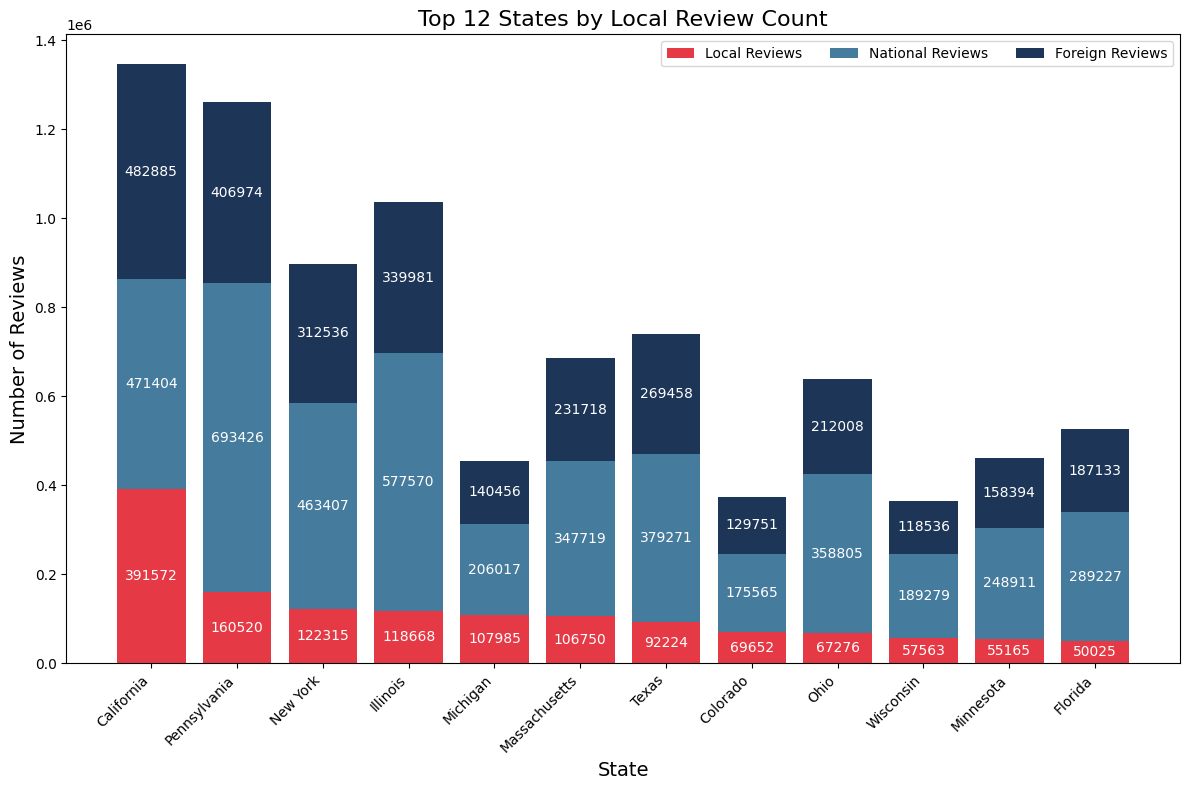

In [5]:
top_n_states = 12

fig, ax = plot_provenance(usa_ratings_merged, states, top_k=top_n_states, sort_option="local_count", 
                          ascending=False, width=0.8, as_ratio=False, colors=us_colors)

ax.set_title(f'Top {top_n_states} States by Local Review Count', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### State wise reviews visualized as an adjacency matrix

For each state we compute the number of reviews from the state to another state. This gives a 50x50 adjacency matrix. We decided to plot it as a heatmap to see if any intersting patterns would arise. For each state we look at the ratio and not the total count as otherwise most of the plot would be black

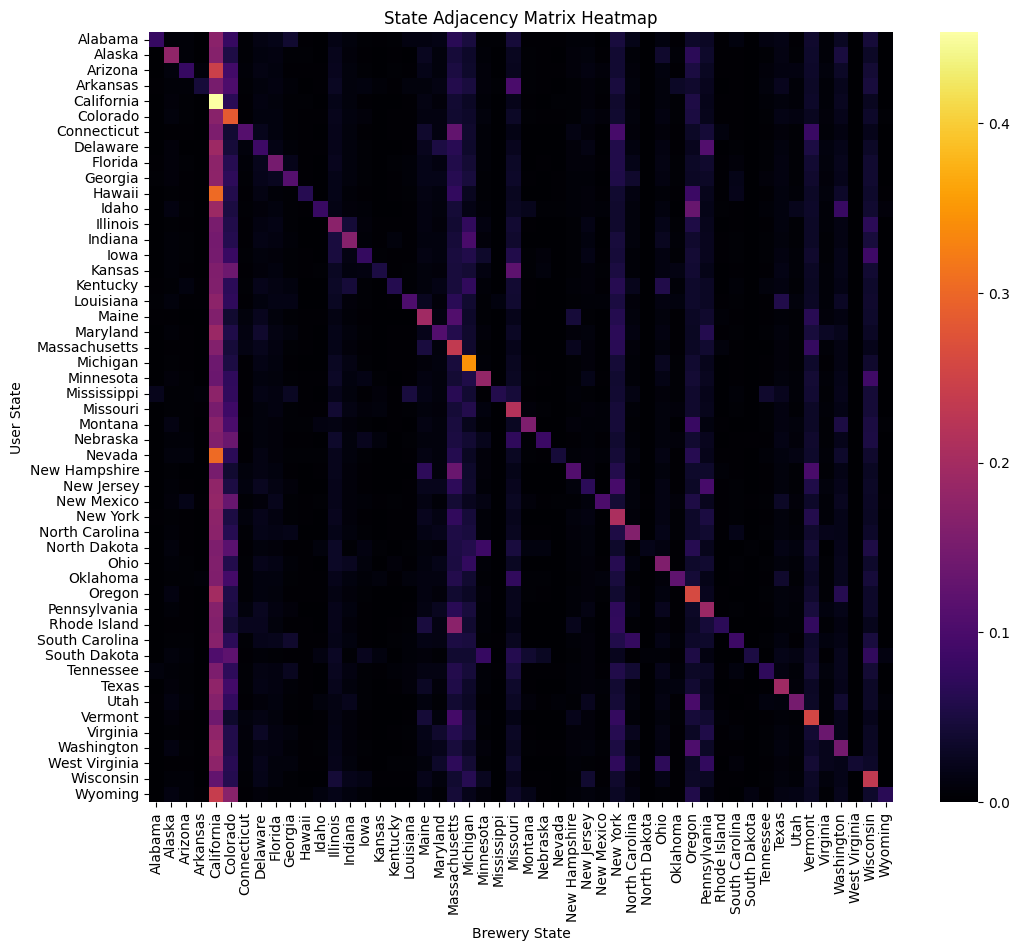

In [6]:
state_adj_matrix = get_state_adjacency_matrix(usa_ratings_merged, states, as_ratio=True, drop_world=True)
plot_state_matrix_as_heatmap(state_adj_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

It seems this somewhat confirms our previous visualization most states review a lot of their own beers. Additionaly it seems some vertical lines appear for a small subset of brewery states which would suggest that most national reviews come from this subset of states, with a majority of national reviews being californian beers.

Interestingly there appears to be a corrolation between the local review ratio of a state and how likely they are to appear significantly in reviews by other states other states. To make this pattern a bit clearer let's order the matrix by local review ratio. However these are probably just states that produce a lot of different beers.

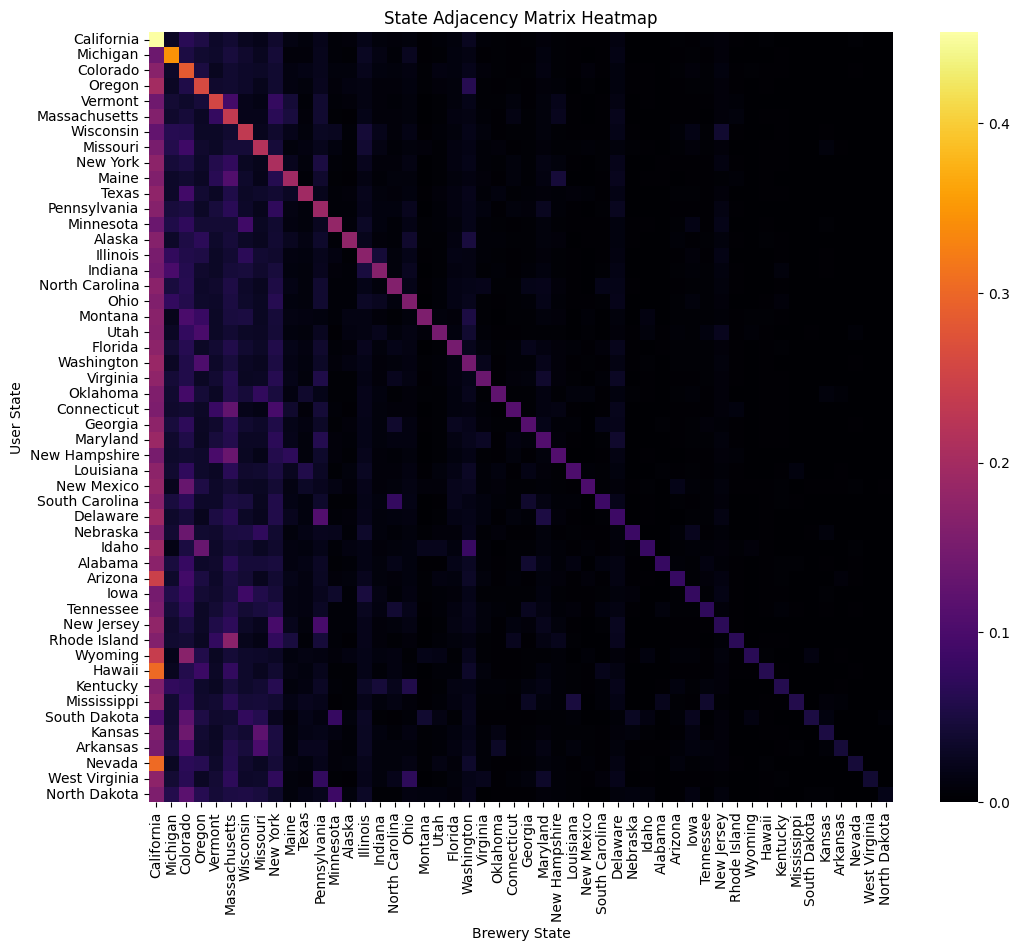

In [7]:
sorted_ajd_matrix = sort_matrix_by_diagonal(state_adj_matrix)
plot_state_matrix_as_heatmap(sorted_ajd_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

In [8]:
# creates a gif of the evolution over time (doesn't diplay it, saves it as a file)
create_yearly_heatmap_gif(usa_ratings_merged, states, "heatmap_yearly.gif")

### Country wise trend of beer

We look at how local, national and foreign reviews evolve over time by looking at the country wise ratios (as in we sum local, national and foreign reviews across all states).

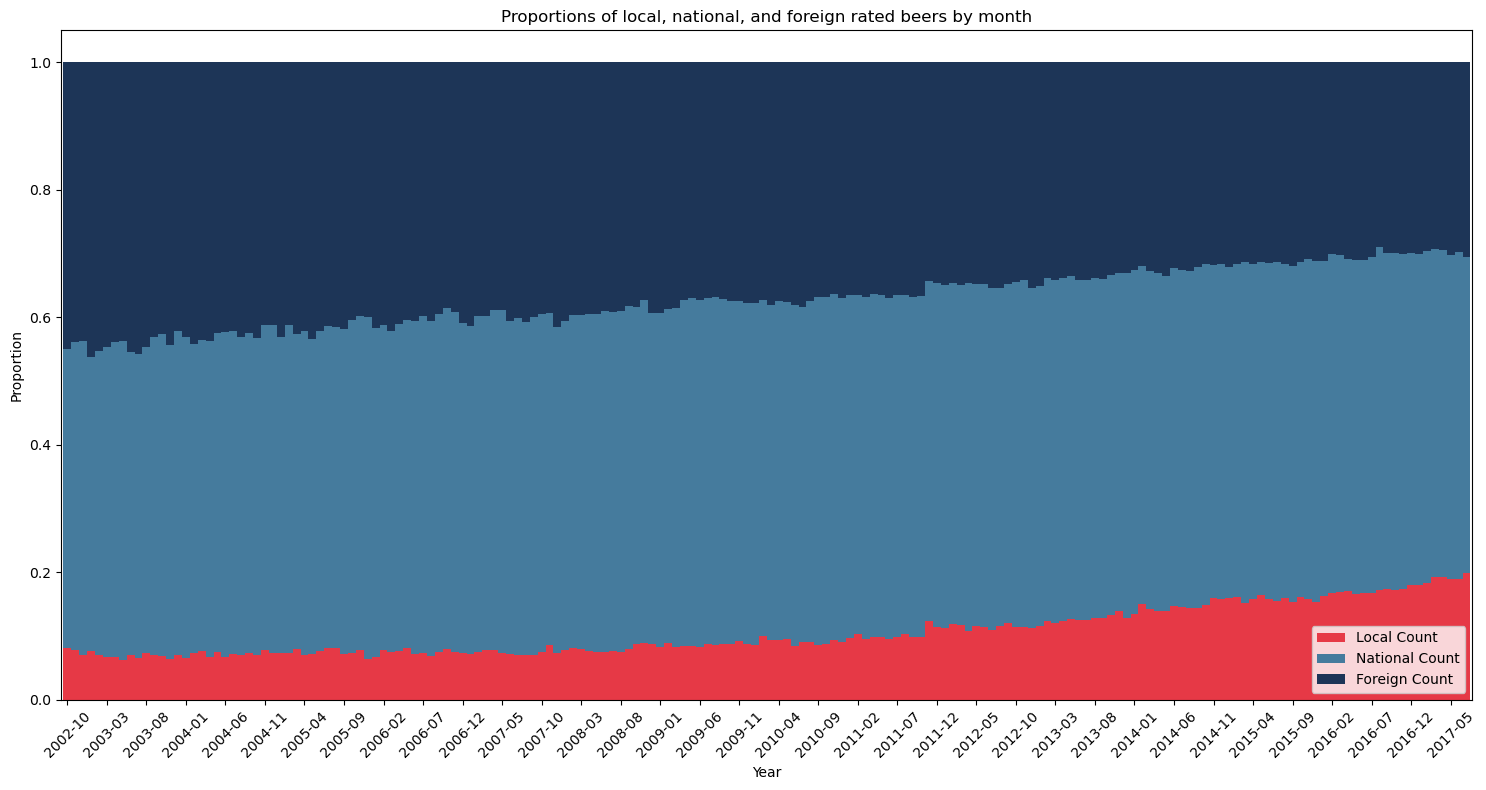

In [9]:
start_month = datetime.strptime("2002-10", "%Y-%m").date()
end_month = datetime.strptime("2017-07", "%Y-%m").date()
us_monthly_ratios = get_monthly_counts_usa(
    usa_ratings_merged, states, start_month=start_month, end_month=end_month, cumulative=False, as_ratio=True
)


fig = plot_monthly_country_counts(
    us_monthly_ratios, 
    title='Proportions of local, national, and foreign rated beers by month',
    xlabel='Year',
    ylabel='Proportion',
    date_steps=5, 
    colors=us_colors
)

# Breweries

We compute the evolution of the number of breweries both in the United States and in the world.

In [ ]:
new_breweries, time_span = breweries_first_date(usa_ratings, breweries)

US_State_index = pd.unique(usa_ratings['state'])
brew_world = monthly_new_breweries(new_breweries, time_span)
brew_us = monthly_new_breweries(new_breweries[new_breweries['location'].isin(US_State_index)], time_span)

In [5]:
cum_brew = brew_world.merge(brew_us, left_index=True, right_index=True, suffixes=('_World', '_US'))
cum_brew['frac'] = cum_brew['cumulative_US'] / cum_brew['cumulative_World']

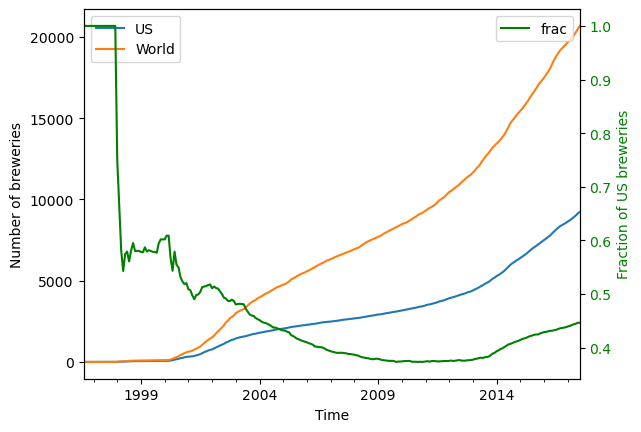

In [10]:
fig, ax = plt.subplots(1, 1)
cum_brew.plot(y= ['cumulative_US', 'cumulative_World'], ax=ax, label=['US', 'World'])
ax.set_xlabel('Time')

ax.legend()

ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
cum_brew.plot(y= ['frac'], ax=ax2, color='g')
ax2.set_ylabel('Fraction of US breweries', color='g')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='g')

ax.set_ylabel("Number of breweries")

plt.show()

## Per state new breweries

This part focuses on the evolution of the number of breweries in the US States.

In [13]:
brewery_state_dic = {}

# the list of state names is the list of unique values of the state of origin of the users, as we only have reviews from users in the US
for state in pd.unique(usa_ratings['state']):
    # New_breweries has already the first review date
    brewery_state_dic[state] = new_breweries[new_breweries['state'] == state]


new_brew_state_dic = {key: {} for key in brewery_state_dic.keys()}
for key in brewery_state_dic.keys():
    new_brew_state_dic[key] = monthly_new_breweries(brewery_state_dic[key], time_span)


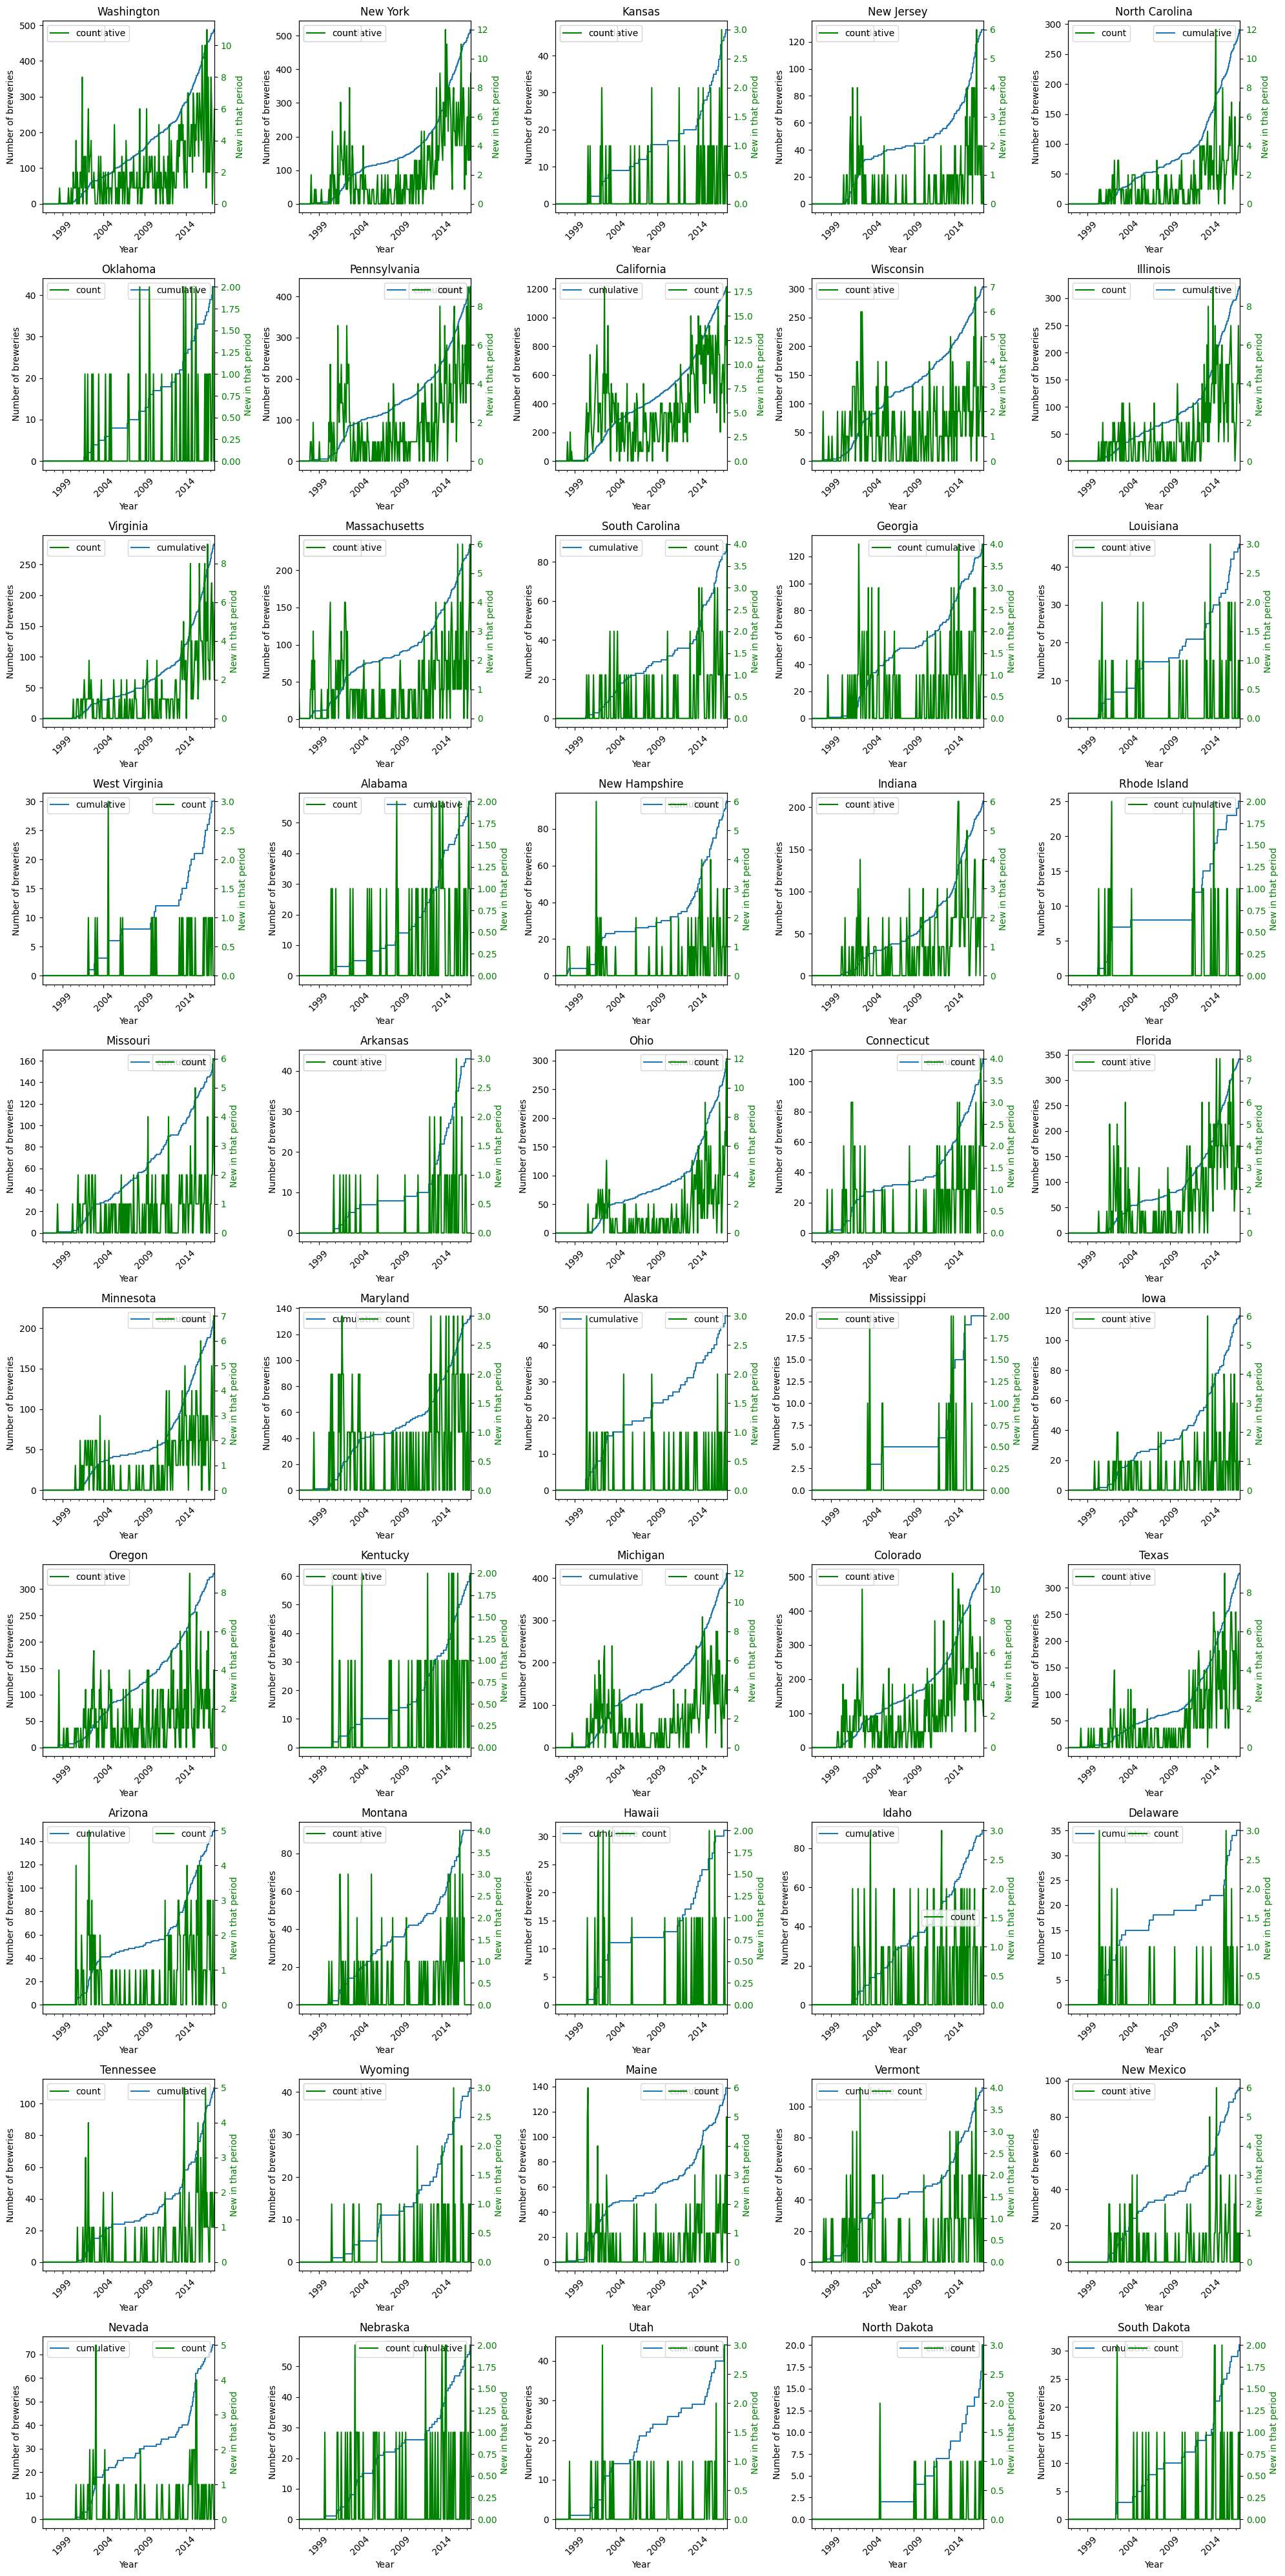

In [14]:
num_states = len(new_brew_state_dic)
cols = 5
rows = math.ceil(num_states / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = axs.flatten()

for i, (state, df) in enumerate(new_brew_state_dic.items()):
    #monthly_avg = df.groupby('year_month')['distance'].mean()
    df.plot(drawstyle="steps", y= ['cumulative'], ax=axs[i], linestyle='-')
    axs[i].set_title(f"{state}")
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Number of breweries")
    axs[i].tick_params(axis='x', rotation=45)

    ax2 = axs[i].twinx()  # instantiate a second Axes that shares the same x-axis
    df.plot(y= ['count'], ax=ax2, color='g')
    ax2.set_ylabel('New in that period', color='g')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='g')


plt.tight_layout()
plt.show()

# Distances

After classifying the beers rated, we now compute the actual distances between the brewery and the place of consumption.

In [16]:
user_state_dic = {}

for state in pd.unique(usa_ratings_merged['user_state']):
    user_state_dic[state] = usa_ratings_merged[usa_ratings_merged['user_state'] == state]

for key in user_state_dic.keys():
    user_state_dic[key] = user_state_dic[key].merge(breweries[['brewery_id', 'state']], on='brewery_id', how='left')
    user_state_dic[key] = user_state_dic[key].rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})

for key in user_state_dic.keys():
    columns_to_keep = [col for col in user_state_dic[key].columns if 'nan' not in col]
    user_state_dic[key] = user_state_dic[key][columns_to_keep]

In [17]:
# writes all distances in a .csv file, to be done only on the first time
#compute_distances(user_state_dic) # parameter is a statewise dictionnary containing all possible relevant pairs of locations

In [ ]:
# load all distances from a .csv file, only works when the cell above has already been run
dict_distances = load_distances("data/clean/")
distance_table = convert_dict_to_table(dict_distances)

In [18]:
#separate in months
usa_ratings_merged['year_month'] = pd.to_datetime(usa_ratings_merged['date']).dt.to_period('M')

for key in user_state_dic.keys():
    user_state_dic[key]['year_month'] = pd.to_datetime(user_state_dic[key]['date']).dt.to_period('M')

In [19]:
#add distance column to each review
for state in user_state_dic.keys():
    user_state_dic[state]['distance'] = user_state_dic[state].apply(lambda row: distance_table.loc[row['user_state'], row['brewery_state']], axis=1)

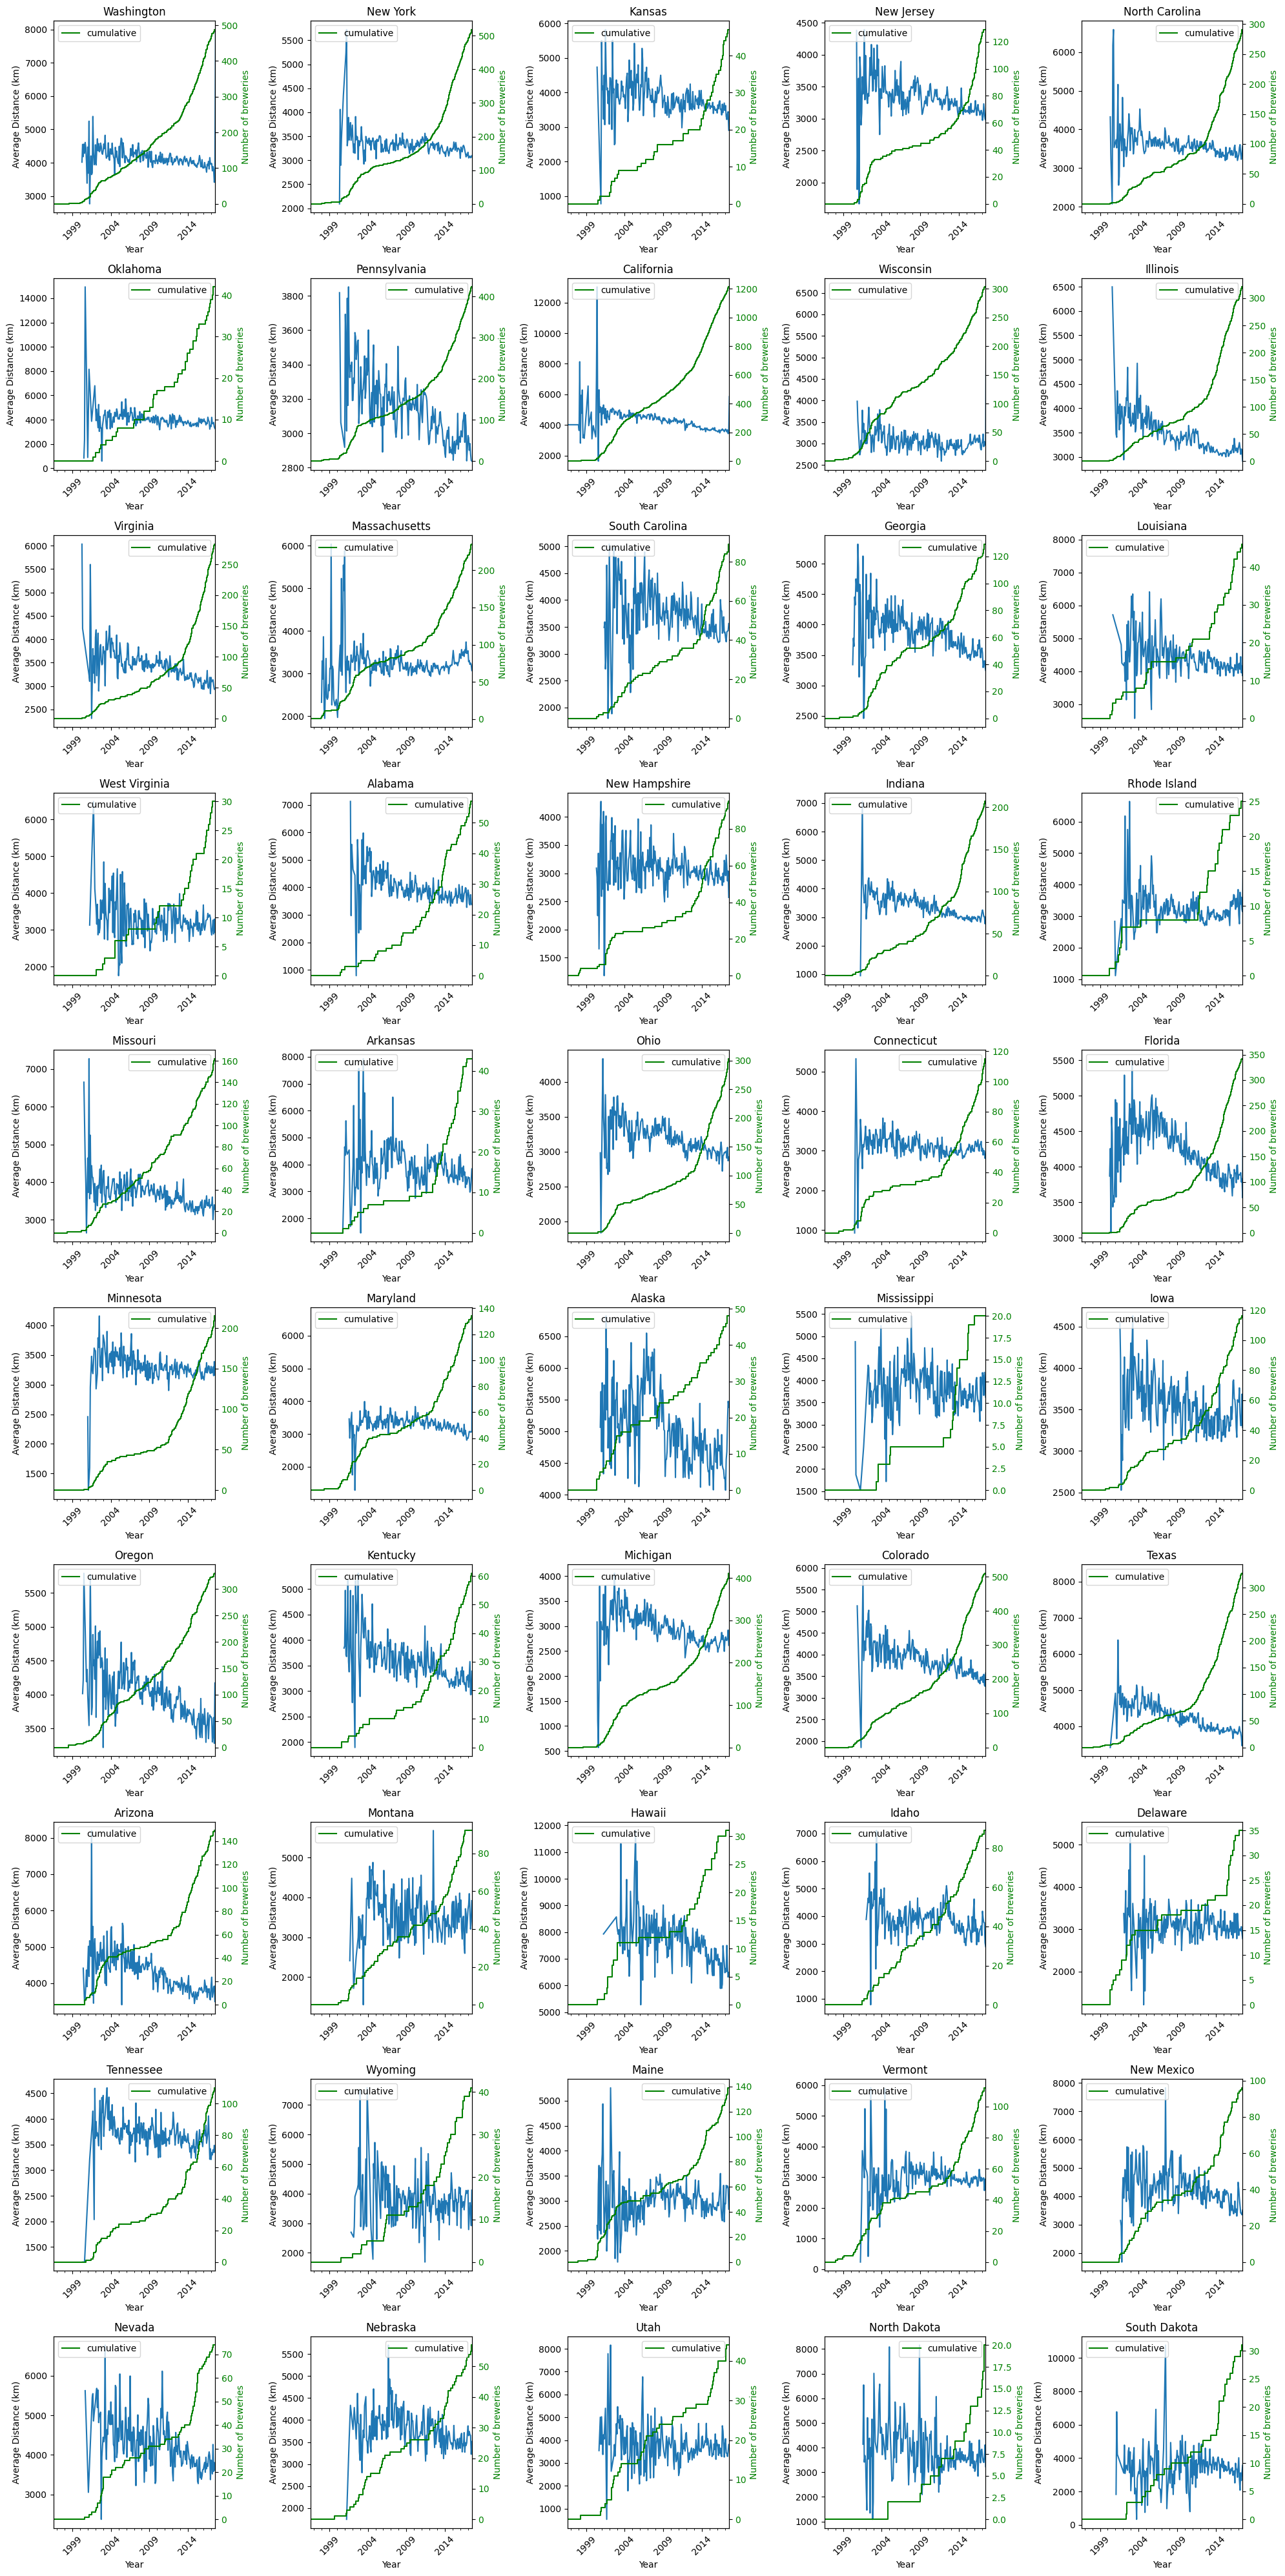

In [23]:
num_states = len(user_state_dic)
cols = 5
rows = math.ceil(num_states / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = axs.flatten()

for i, (state, df) in enumerate(user_state_dic.items()):
    monthly_avg = df.groupby('year_month')['distance'].mean()
    monthly_avg.plot(ax=axs[i], linestyle='-')
    axs[i].set_title(f"{state}")
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Average Distance (km)")
    axs[i].tick_params(axis='x', rotation=45)

    ax2 = axs[i].twinx()
    # new brweries in that state
    new_brew_state_dic[state].plot(drawstyle="steps", y=['cumulative'], ax=ax2, linestyle='-', color='g')
    ax2.set_ylabel('Number of breweries', color='g')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='g')

plt.tight_layout()
plt.show()

After looking at the statewise data, we now look at the national average.

In [42]:
usa_ratings_merged['distance'] = usa_ratings_merged.apply(lambda row: distance_table.loc[row['user_state'], row['brewery_state']], axis=1)

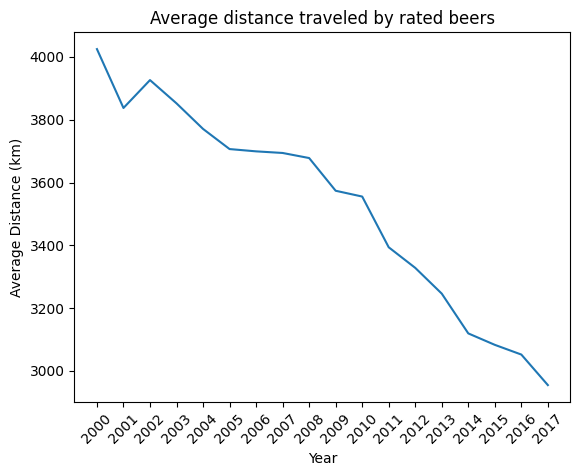

In [52]:
usa_ratings_merged['year'] = usa_ratings_merged['year_month'].dt.year
average_distance_per_year = usa_ratings_merged.groupby('year')['distance'].mean()
average_distance_per_year = average_distance_per_year[average_distance_per_year.index >= 2000] #only take data after 2000 (too few points before)

plt.plot(average_distance_per_year.index, average_distance_per_year)
plt.title('Average Distance traveled by rated beers')
plt.xlabel('Year')
plt.ylabel('Average Distance (km)')
plt.xticks(ticks=range(2000, average_distance_per_year.index.max() + 1), rotation=45)
plt.show()